In [1]:
# !pip install kaggle
# !pip install kagglehub

# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install Pillow
# !pip install scikit-learn

# !pip install seaborn

# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# !pip install torchsummary

# Setup

In [2]:
# Copy from kaggle
import kagglehub

# Download latest version
org_path = kagglehub.dataset_download("lantian773030/pokemonclassification")

print("Path to dataset files:", org_path)


Path to dataset files: C:\Users\CindyHong\.cache\kagglehub\datasets\lantian773030\pokemonclassification\versions\1


In [3]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import ImageOps,ImageEnhance
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import torch
import torch.nn.functional as F
import torch.nn as nn
from torchsummary import summary
import torchvision.transforms as transforms
from torch import optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.metrics import confusion_matrix
from torch.utils.data import random_split
import scipy

from torchvision import models
from sklearn.utils.class_weight import compute_class_weight

import gc


In [4]:
np.random.seed(2024)

In [5]:
# Setting dataset path
path = os.path.join(org_path,'PokemonData')
path

'C:\\Users\\CindyHong\\.cache\\kagglehub\\datasets\\lantian773030\\pokemonclassification\\versions\\1\\PokemonData'

In [6]:
class_list = pd.read_csv('class_sheet.csv')

In [7]:
bad_class_list = class_list[class_list['Bad_Data'] == 1]['Pokemon']
bad_image_paths = []
valid_extensions = ['.jpg', '.jpeg', '.png']

In [8]:
# Removing all classes with bad data
class_list = class_list[class_list['Bad_Data'] != 1]

In [9]:
# Getting Pokemons that are winged and not winged
winged = class_list[class_list['Winged'] == 1]
winged = winged['Pokemon']
not_winged = class_list[class_list['Not_Winged'] == 1]
not_winged = not_winged['Pokemon']

In [10]:
# Making a data frame that has the image arrays and their classifcation
images = []
# wrong_extensions = []

for folder in winged:
    image_names = os.listdir(os.path.join(path,folder))
    for image in image_names:
        file_extension = os.path.splitext(image)[1]
        # Sanity check to make sure all file paths exist
        if file_extension not in valid_extensions:
            # wrong_extensions.append(file_extension)
            continue
        image_path = os.path.join(path,folder,image)
        # if not os.path.exists(image_path):
            # print(image_path)
            # continue
        with Image.open(image_path) as img:
            img = np.array(img)
            images.append({'Image': img, 'Source': 'Winged'})
        del img
        gc.collect()
            
for folder in not_winged:
    image_names = os.listdir(os.path.join(path,folder))
    for image in image_names:
        file_extension = os.path.splitext(image)[1]
        # Sanity check to make sure all file paths exist
        if file_extension not in valid_extensions:
            # wrong_extensions.append(file_extension)
            continue
        image_path = os.path.join(path,folder,image)
        # if not os.path.exists(image_path):
            # print(image_path)
            # continue
        with Image.open(image_path) as img:
            img = np.array(img)
            images.append({'Image': img, 'Source': 'Not Winged'})
            
df = pd.DataFrame(images)
# set(wrong_extensions)

In [11]:
# Sanity check to make sure there are only 2 classes
for index, row in df.iterrows():
    if row['Source'] not in ['Winged', 'Not Winged']:
        print(row)

# Data Preprocessing

In [12]:
# Normalizing function
def zscore(img,default = False):
    img = img.astype(np.float32)
    for c in range(img.shape[2]):
        if not default:
            mean = img[:,:,c].mean()
            std = img[:,:,c].std()
        else:
            mean=[0.485, 0.456, 0.406][c]
            std=[0.229, 0.224, 0.225][c]
        if std > 0:
            img[:,:,c] = (img[:,:,c] - mean) / std
        else:
            img[:,:,c] = (img[:,:,c] - mean)
    return img

def minmax(img):
    img = img.astype(np.float32)
    for c in range(img.shape[2]):
        max = img[:,:,c].max()
        min = img[:,:,c].min()
        img[:,:,c] = (img[:,:,c] - min) / (max - min)
    return img

In [13]:
# Going through all images and resizing them, converting them to grayscale or RGB and normalizing pixel values
def preprocess(df, pattern, default=False, batch_size=50):
    X = []
    y = []
    new_size = (224, 224)
    for start in range(0, len(df), batch_size):
        batch_df = df.iloc[start:start + batch_size]
        X_batch = []
        y_batch = []
        for _, row in batch_df.iterrows():
            # Resize images to 224 x 224
            img = Image.fromarray(row['Image']).resize(new_size)
            if pattern == 'Grayscale':
                # Convert images to grayscale
                img = img.convert('L')
                img = np.array(img) / 255.0
            else:
                img = img.convert('RGB')
                img = np.array(img)
                # Zscore normalization
                if pattern == 'Zscore':
                    img = zscore(img, default=default)
                # Minmax normalization
                elif pattern == 'Minmax':
                    img = minmax(img)

            X_batch.append(img)
            y_batch.append(1 if row['Source'] == 'Winged' else 0)
        
        X.append(np.array(X_batch))
        y.append(np.array(y_batch))
        
        del X_batch, y_batch
        gc.collect()
    
    X = np.concatenate(X, axis=0)
    y = np.concatenate(y, axis=0)
    return X, y
# (n,224,224,3) or (n,224,224)

In [14]:
pattern = 'Zscore'
X,y = preprocess(df,pattern)
X.shape

(6017, 224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

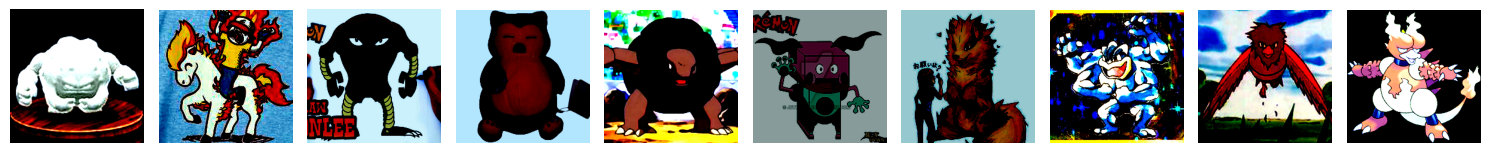

In [15]:
# Plotting 10 images after Zscore
X_random_id = np.random.choice(X.shape[0], 10, replace=False)
X_random = X[X_random_id]
plt.figure(figsize=(15, 10))
for i, img in enumerate(X_random):
    plt.subplot(1, 10, i + 1)  
    plt.imshow(img) 
    plt.axis('off') 
plt.tight_layout()
plt.show()

In [16]:
pattern = 'Minmax'
X,y = preprocess(df,pattern)
X.shape

(6017, 224, 224, 3)

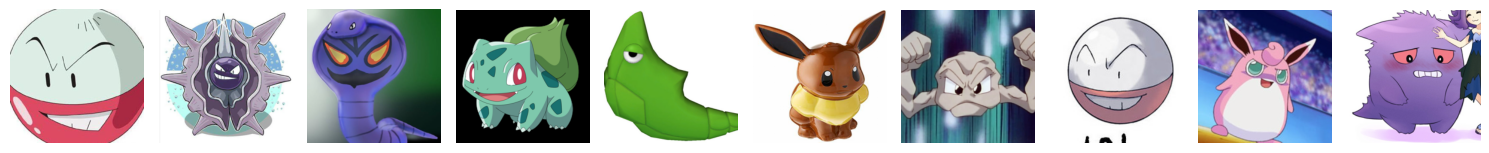

In [17]:
# Plotting 10 images after Minmax
X_random_id = np.random.choice(X.shape[0], 10, replace=False)
X_random = X[X_random_id]
plt.figure(figsize=(15, 10))
for i, img in enumerate(X_random):
    plt.subplot(1, 10, i + 1)  
    plt.imshow(img) 
    plt.axis('off') 
plt.tight_layout()
plt.show()

In [18]:
pattern = 'Grayscale'
X,y = preprocess(df,pattern)
X.shape

(6017, 224, 224)

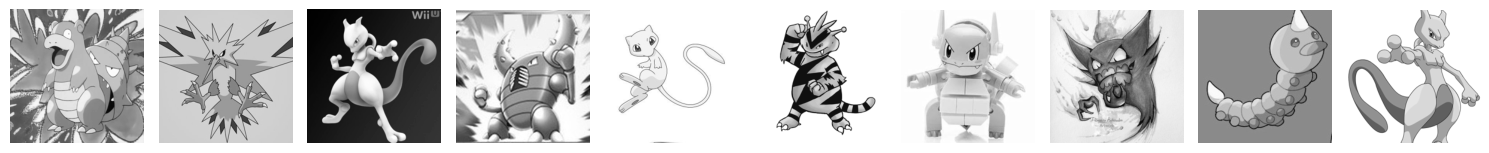

In [19]:
# Plotting 10 images after Grayscale
X_random_id = np.random.choice(X.shape[0], 10, replace=False)
X_random = X[X_random_id]
plt.figure(figsize=(15, 10))
for i, img in enumerate(X_random):
    plt.subplot(1, 10, i + 1)  
    plt.imshow(img,cmap="gray") 
    plt.axis('off') 
plt.tight_layout()
plt.show()

In [20]:
######## We can also use some optimization methods to train on imbalanced dataset ########
# Balancing the data set by random sampling
def random_sample(X,y):
    id_not_winged = np.where(y == 0)[0]
    id_winged = np.where(y == 1)[0]
    sample_not_winged = np.random.choice(id_not_winged, size=600, replace=False)
    sample_winged = np.random.choice(id_winged, size=600, replace=False)
    sample = np.concatenate((sample_not_winged, sample_winged), axis=0)
    X = X[sample]
    y = y[sample]
    return X,y
######## We can also use some optimization methods to train on imbalanced dataset ########

# Creating Train/Validate/Test splits (80/10/10)
def random_split(X,y):
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=2024, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=2024, stratify=y_temp)
    return X_train, X_val, X_test, y_train, y_val,y_test

# X , y = random_sample(X,y)
# X_train, X_val, X_test, y_train, y_val,y_test = random_split(X,y)

In [21]:
# Augmentation function
# Our resized image doesn't have enough space for shearing or zooming
def augmentation(img,pattern,img_size=(224,224),horizontal_flip=True,vertical_flip=False,rotation_range=20, horizontal_shift=0.2, vertical_shift=0.2):
    if img.dtype == np.float32:
        img = (img * 255).astype(np.uint8)
    if pattern != 'Grayscale':
        mean = tuple(np.mean(img,axis=(0,1)).astype(int))
    else:
        mean = 0
    if isinstance(img, np.ndarray):
        img = Image.fromarray(img)
    # Flipping
    if horizontal_flip and np.random.random() < 0.5:
        img = img.transpose(Image.Transpose.FLIP_LEFT_RIGHT)
    if vertical_flip and np.random.random() < 0.5:
        img = img.transpose(Image.Transpose.FLIP_TOP_BOTTOM)
    # Rotating
    if rotation_range > 0:
        rotation_range = np.random.randint(-rotation_range, rotation_range)
        img = img.rotate(rotation_range, resample=Image.BICUBIC,fillcolor=mean)
    # Shifting
    if horizontal_shift > 0 or vertical_shift > 0:
        w , h = img_size
        dw = np.random.randint(-horizontal_shift * w, horizontal_shift * w)
        dh = np.random.randint(-vertical_shift * h, vertical_shift * h)
        img = ImageOps.expand(img, border=(abs(dw),abs(dh),abs(dw),abs(dh)),fill=mean)
        img = img.crop((dw+abs(dw),dh+abs(dh),dw+abs(dw)+w,dh+abs(dh)+h))
    # Ensure the sizes
    img = img.resize(img_size)
    img = np.array(img).astype(np.float32) / 255.0
    return img

In [22]:
# Going through all images and augment them
def augment_loop(X_train,y_train,pattern,img_size=(224,224),horizontal_flip=True,vertical_flip=False,rotation_range=20, horizontal_shift=0.2, vertical_shift=0.2):
    X_augmented = []
    y_augmented = []
    for img, label in zip(X_train,y_train):
        X_augmented.append(img)
        img = augmentation(img,pattern,img_size,horizontal_flip,vertical_flip,rotation_range, horizontal_shift, vertical_shift)
        X_augmented.append(img)
        y_augmented.append(label)
        y_augmented.append(label)
        # del img,label
        # gc.collect()
    X_train = np.array(X_augmented)
    y_train = np.array(y_augmented)
    return X_train, y_train

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


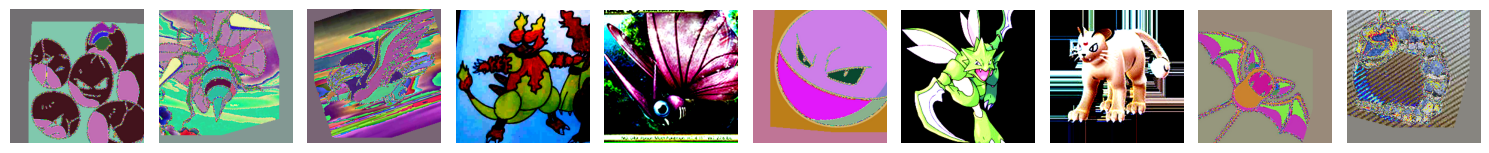

In [23]:
# Plotting 10 images after augmenting
pattern = 'Zscore'
X,y = preprocess(df,pattern)
X , y = random_sample(X,y)
X_train, X_val, X_test, y_train, y_val,y_test = random_split(X,y)
X_train, y_train = augment_loop(X_train,y_train,pattern)
X_random_id = np.random.choice(X_train.shape[0], 10, replace=False)
X_random = X_train[X_random_id]
plt.figure(figsize=(15, 10))
for i, img in enumerate(X_random):
    plt.subplot(1, 10, i + 1)  
    plt.imshow(img) 
    plt.axis('off') 
plt.tight_layout()
plt.show()

In [24]:
X_train.shape, X_val.shape, X_test.shape

((1920, 224, 224, 3), (120, 224, 224, 3), (120, 224, 224, 3))

# Model Training

## ML

### Data Visualization

In [26]:
# Print classification report and Plot confusion matrix
def report_cm(model,X_train,y_train,X_val,y_val,X_test,y_test):
    y_train_pred = model.predict(X_train)
    print(classification_report(y_train,y_train_pred))
    cm_train = confusion_matrix(y_train,y_train_pred)
    
    y_val_pred = model.predict(X_val)
    print(classification_report(y_val,y_val_pred))
    cm_val = confusion_matrix(y_val,y_val_pred)
    
    y_test_pred = model.predict(X_test)
    print(classification_report(y_test,y_test_pred))
    cm_test = confusion_matrix(y_test,y_test_pred)
    
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - Train')
    plt.subplot(1, 3, 2)
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - Val')
    plt.subplot(1, 3, 3)
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - Test')
    plt.show()


### Logistic Regression

In [27]:
pattern = 'Minmax'
X,y = preprocess(df,pattern)
X , y = random_sample(X,y)
X_train, X_val, X_test, y_train, y_val,y_test = random_split(X,y)
X_train, y_train = augment_loop(X_train,y_train,pattern)

In [28]:
X_train.shape

(1920, 224, 224, 3)

In [29]:
X_flattened_train = X_train.reshape(X_train.shape[0], -1)
X_flattened_val = X_val.reshape(X_val.shape[0], -1)
X_flattened_test = X_test.reshape(X_test.shape[0], -1)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       960
           1       1.00      1.00      1.00       960

    accuracy                           1.00      1920
   macro avg       1.00      1.00      1.00      1920
weighted avg       1.00      1.00      1.00      1920

              precision    recall  f1-score   support

           0       0.65      0.53      0.59        60
           1       0.61      0.72      0.66        60

    accuracy                           0.62       120
   macro avg       0.63      0.62      0.62       120
weighted avg       0.63      0.62      0.62       120

              precision    recall  f1-score   support

           0       0.53      0.48      0.50        60
           1       0.52      0.57      0.54        60

    accuracy                           0.53       120
   macro avg       0.53      0.53      0.52       120
weighted avg       0.53      0.53      0.52       120



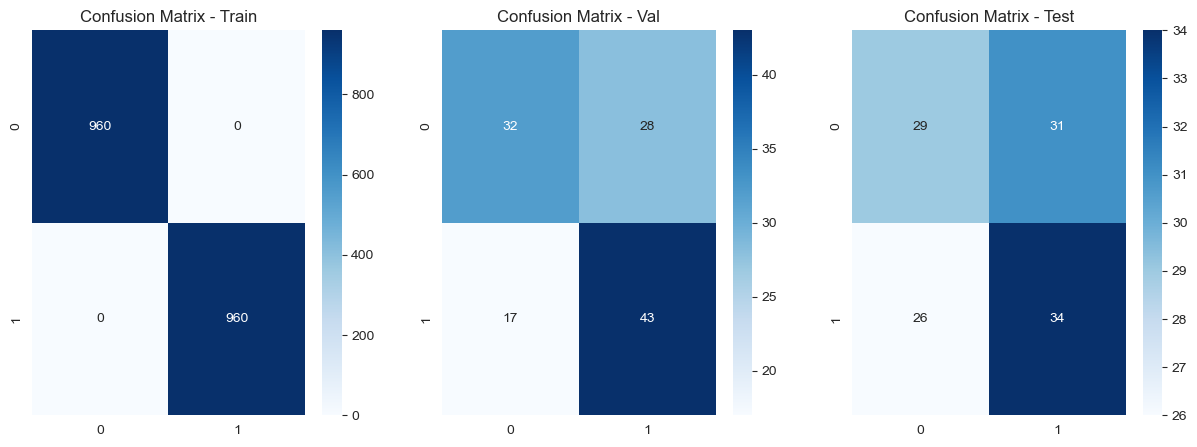

In [30]:
LR = LogisticRegression(max_iter=1000)
LR.fit(X_flattened_train, y_train)

report_cm(LR,X_flattened_train,y_train,X_flattened_val,y_val,X_flattened_test,y_test)

### SVM

In [31]:
# pattern = 'Minmax'
# X,y = preprocess(df,pattern)
# X , y = random_sample(X,y)
# X_train, X_val, X_test, y_train, y_val,y_test = random_split(X,y)
# X_train, y_train = augment_loop(X_train,y_train,pattern)

In [32]:
# X_flattened_train = X_train.reshape(X_train.shape[0], -1)
# X_flattened_val = X_val.reshape(X_val.shape[0], -1)
# X_flattened_test = X_test.reshape(X_test.shape[0], -1)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       960
           1       1.00      1.00      1.00       960

    accuracy                           1.00      1920
   macro avg       1.00      1.00      1.00      1920
weighted avg       1.00      1.00      1.00      1920

              precision    recall  f1-score   support

           0       0.65      0.53      0.59        60
           1       0.61      0.72      0.66        60

    accuracy                           0.62       120
   macro avg       0.63      0.62      0.62       120
weighted avg       0.63      0.62      0.62       120

              precision    recall  f1-score   support

           0       0.53      0.48      0.50        60
           1       0.52      0.57      0.54        60

    accuracy                           0.53       120
   macro avg       0.53      0.53      0.52       120
weighted avg       0.53      0.53      0.52       120



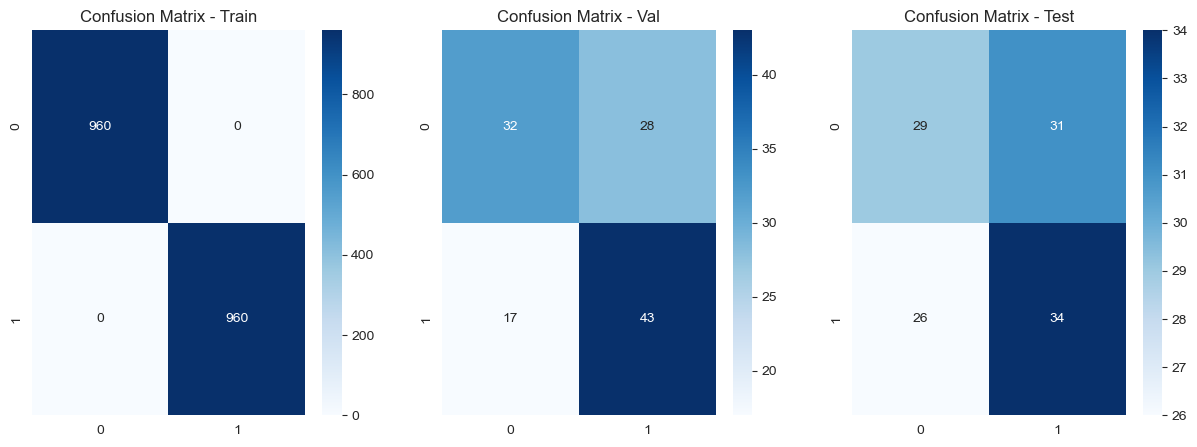

In [33]:
svm_rbf = SVC(kernel = 'rbf')
svm_rbf.fit(X_flattened_train, y_train)

report_cm(LR,X_flattened_train,y_train,X_flattened_val,y_val,X_flattened_test,y_test)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       960
           1       1.00      1.00      1.00       960

    accuracy                           1.00      1920
   macro avg       1.00      1.00      1.00      1920
weighted avg       1.00      1.00      1.00      1920

              precision    recall  f1-score   support

           0       0.65      0.53      0.59        60
           1       0.61      0.72      0.66        60

    accuracy                           0.62       120
   macro avg       0.63      0.62      0.62       120
weighted avg       0.63      0.62      0.62       120

              precision    recall  f1-score   support

           0       0.53      0.48      0.50        60
           1       0.52      0.57      0.54        60

    accuracy                           0.53       120
   macro avg       0.53      0.53      0.52       120
weighted avg       0.53      0.53      0.52       120



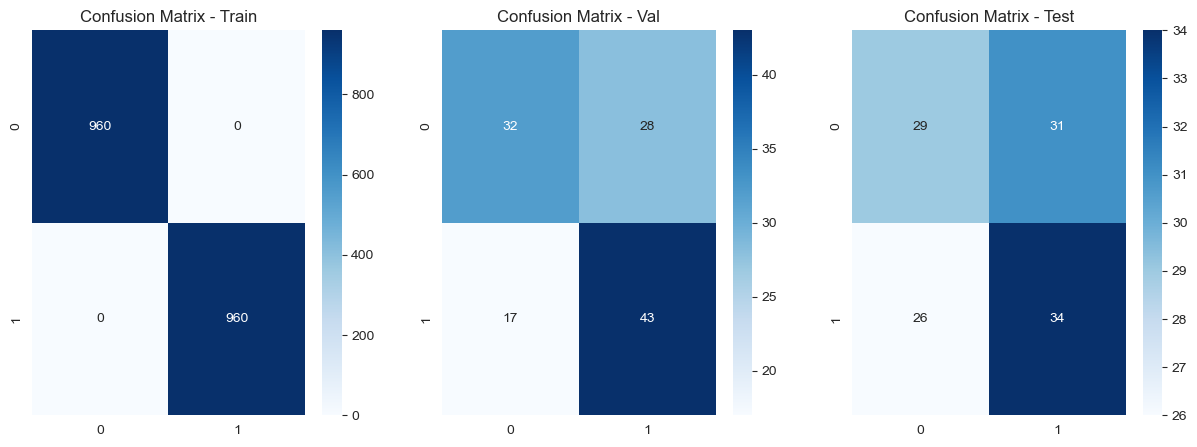

In [34]:
svm_poly = SVC(kernel = 'poly')
svm_poly.fit(X_flattened_train, y_train)

report_cm(LR,X_flattened_train,y_train,X_flattened_val,y_val,X_flattened_test,y_test)

### KNN

In [51]:
pattern = 'Minmax'
X,y = preprocess(df,pattern)
X , y = random_sample(X,y)
X_train, X_val, X_test, y_train, y_val,y_test = random_split(X,y)
X_train, y_train = augment_loop(X_train,y_train,pattern)

In [52]:
X_flattened_train = X_train.reshape(X_train.shape[0], -1)
X_flattened_val = X_val.reshape(X_val.shape[0], -1)
X_flattened_test = X_test.reshape(X_test.shape[0], -1)

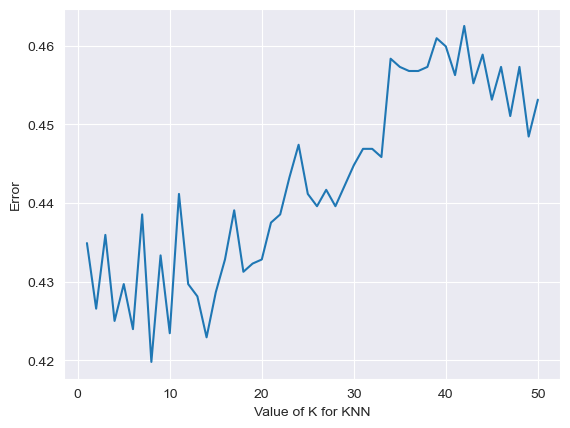

In [53]:
# Picking suitable value of k
from sklearn.model_selection import cross_val_score
k_range = range(1, 51)
k_error = []
k_best_score = 0
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_flattened_train, y_train, cv=6, scoring='accuracy', verbose=1)
    if scores.mean() > k_best_score:
        k_best_score = scores.mean()
        k_best = k
    k_error.append(1 - scores.mean())
plt.plot(k_range, k_error)
plt.xlabel('Value of K for KNN')
plt.ylabel('Error')
plt.show()


In [54]:
print(k_best)

8


              precision    recall  f1-score   support

           0       0.63      0.55      0.59       960
           1       0.60      0.67      0.63       960

    accuracy                           0.61      1920
   macro avg       0.61      0.61      0.61      1920
weighted avg       0.61      0.61      0.61      1920

              precision    recall  f1-score   support

           0       0.81      0.57      0.67        60
           1       0.67      0.87      0.75        60

    accuracy                           0.72       120
   macro avg       0.74      0.72      0.71       120
weighted avg       0.74      0.72      0.71       120

              precision    recall  f1-score   support

           0       0.83      0.42      0.56        60
           1       0.61      0.92      0.73        60

    accuracy                           0.67       120
   macro avg       0.72      0.67      0.64       120
weighted avg       0.72      0.67      0.64       120



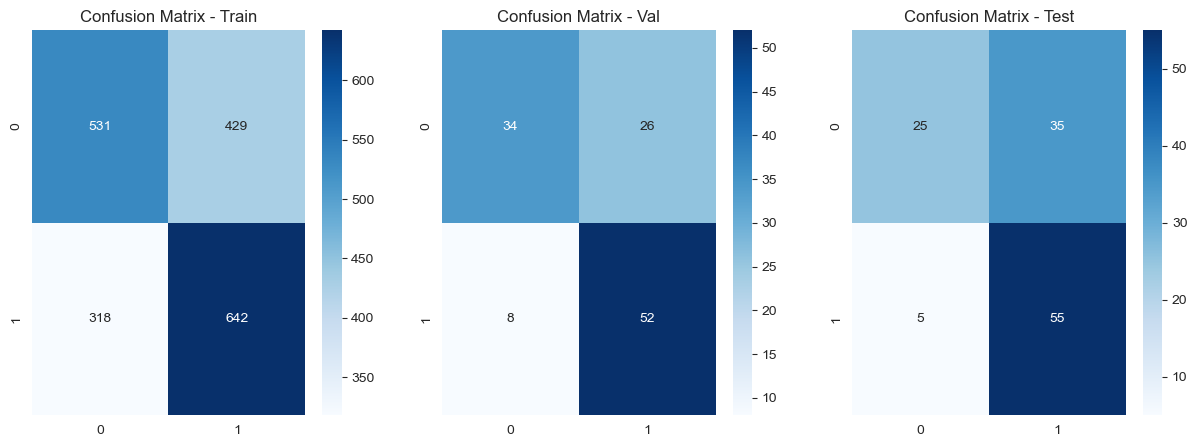

In [55]:
k=k_best
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_flattened_train, y_train)

report_cm(LR,X_flattened_train,y_train,X_flattened_val,y_val,X_flattened_test,y_test)


### Naive Bayes

In [40]:
pattern = 'Zscore'
X,y = preprocess(df,pattern)
X , y = random_sample(X,y)
X_train, X_val, X_test, y_train, y_val,y_test = random_split(X,y)
# X_train, y_train = augment_loop(X_train,y_train,pattern)

In [41]:
X_flattened_train = X_train.reshape(X_train.shape[0], -1)
X_flattened_val = X_val.reshape(X_val.shape[0], -1)
X_flattened_test = X_test.reshape(X_test.shape[0], -1)

              precision    recall  f1-score   support

           0       0.78      0.57      0.66       480
           1       0.66      0.84      0.74       480

    accuracy                           0.71       960
   macro avg       0.72      0.71      0.70       960
weighted avg       0.72      0.71      0.70       960

              precision    recall  f1-score   support

           0       0.74      0.53      0.62        60
           1       0.64      0.82      0.72        60

    accuracy                           0.68       120
   macro avg       0.69      0.68      0.67       120
weighted avg       0.69      0.68      0.67       120

              precision    recall  f1-score   support

           0       0.79      0.62      0.69        60
           1       0.68      0.83      0.75        60

    accuracy                           0.72       120
   macro avg       0.74      0.73      0.72       120
weighted avg       0.74      0.72      0.72       120



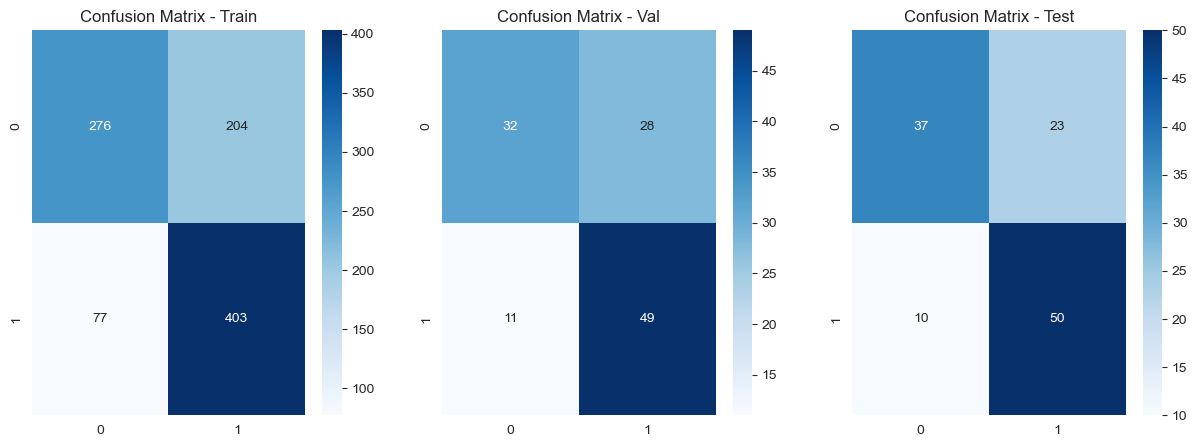

In [42]:
NB = GaussianNB()
NB.fit(X_flattened_train, y_train)

report_cm(LR,X_flattened_train,y_train,X_flattened_val,y_val,X_flattened_test,y_test)

## DL

### Data Visualization

In [25]:
def calculate_accuracy(loader, model, device):
    model.eval() 
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

def get_losses(losses,loader, model, device):
    loss = 0.0
    model.eval() 
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            l = criterion(outputs, targets)
            loss += l.item()
    loss /= len(loader)
    losses.append(loss)
    return losses

def get_predictions(loader, model, device):
    all_targets = []
    all_predictions = []
    model.eval() 
    # for epoch in range(epoches):
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    return all_targets,all_predictions

# Plot loss curve and confusion matrix for NNs
def loss_curve(epoches,train_losses,val_losses):
    # loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epoches + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epoches + 1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Testing Loss Curve')
    plt.legend()
    plt.show()

def plot_confusion_matrix(all_train_targets,all_train_predictions,all_val_targets,all_val_predictions,all_test_targets,all_test_predictions):

    plt.figure(figsize=(18, 5))
    plt.subplot(1, 3, 1)
    # calculate confusion matrix
    cm = confusion_matrix(all_train_targets, all_train_predictions)
    # plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix - Train')
    
    plt.subplot(1, 3, 2)
    # calculate confusion matrix
    cm = confusion_matrix(all_val_targets, all_val_predictions)
    # plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix - Val')

    
    plt.subplot(1, 3, 3)
    # calculate confusion matrix
    cm = confusion_matrix(all_test_targets, all_test_predictions)
    # plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix - Test')
    plt.show()
    
def print_confusion_matrix(all_train_targets,all_train_predictions,all_val_targets,all_val_predictions,all_test_targets,all_test_predictions):
    print(classification_report(all_train_targets,all_train_predictions))
    print(classification_report(all_val_targets,all_val_predictions))
    print(classification_report(all_test_targets,all_test_predictions))
    

### Dataloader

In [26]:
class ImageDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = torch.tensor(self.data[idx],dtype=torch.float32)
        label = torch.tensor(self.labels[idx],dtype=torch.long)
        
        return image, label

### CNN

In [58]:
class CNN(nn.Module):
    def __init__(self,image_size=(3,224,224), num_classes=2,dropout = 0.25):
        super(CNN, self).__init__()
        c,h,w = image_size
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        # self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        # self.bn3 = nn.BatchNorm2d(256)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout)
        self.flattened_size = 128 * (h // 4) * (w // 4) 
        self.fc = nn.Linear(self.flattened_size, num_classes)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        # x = self.bn3(self.conv3(x))
        # x = self.pool(x)
        
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [59]:
pattern = 'Minmax'
X,y = preprocess(df,pattern)
X , y = random_sample(X,y)
X_train, X_val, X_test, y_train, y_val,y_test = random_split(X,y)
X_train, y_train = augment_loop(X_train,y_train,pattern)

In [60]:
X_train = X_train.transpose(0,3,1,2)
X_val = X_val.transpose(0,3,1,2)
X_test = X_test.transpose(0,3,1,2)
X_train.shape

(1920, 3, 224, 224)

In [61]:
torch.manual_seed(2024)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

CNN = CNN().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(CNN.parameters(),lr=0.01,weight_decay=1e-4)

epoches = 25
best_val_accuracy = 0
datas = []
val_datas = []

# Create DataLoaders for training and testing
dataset = ImageDataset(X_train,y_train)
val_dataset = ImageDataset(X_val,y_val)
test_dataset = ImageDataset(X_test,y_test)

train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

train_losses = []
val_losses = []

for epoch in range(epoches):
    CNN.train()
       
    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = CNN(inputs)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    
    train_accuracy = calculate_accuracy(train_loader, CNN, device)
    val_accuracy = calculate_accuracy(val_loader, CNN, device)
    
    print(f"Epoch [{epoch + 1}/{epoches}], "
          f"Loss: {loss.item() / len(train_loader):.4f}, "
          f"Train Accuracy: {train_accuracy:.2f}%, "
          f"Test Accuracy: {val_accuracy:.2f}%")
    
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(CNN.state_dict(), 'best_model_CNN.pth')
    
    train_losses = get_losses(train_losses,train_loader, CNN, device)
    val_losses = get_losses(val_losses,val_loader, CNN, device)



cuda
Epoch [1/25], Loss: 1.0708, Train Accuracy: 60.26%, Test Accuracy: 57.50%
Epoch [2/25], Loss: 0.1670, Train Accuracy: 64.17%, Test Accuracy: 58.33%
Epoch [3/25], Loss: 0.0581, Train Accuracy: 70.31%, Test Accuracy: 58.33%
Epoch [4/25], Loss: 0.0656, Train Accuracy: 77.86%, Test Accuracy: 61.67%
Epoch [5/25], Loss: 0.0113, Train Accuracy: 76.93%, Test Accuracy: 65.00%
Epoch [6/25], Loss: 0.0102, Train Accuracy: 86.93%, Test Accuracy: 65.00%
Epoch [7/25], Loss: 0.0065, Train Accuracy: 90.31%, Test Accuracy: 60.83%
Epoch [8/25], Loss: 0.0094, Train Accuracy: 91.15%, Test Accuracy: 68.33%
Epoch [9/25], Loss: 0.0029, Train Accuracy: 89.69%, Test Accuracy: 62.50%
Epoch [10/25], Loss: 0.0028, Train Accuracy: 91.77%, Test Accuracy: 66.67%
Epoch [11/25], Loss: 0.0022, Train Accuracy: 92.81%, Test Accuracy: 66.67%
Epoch [12/25], Loss: 0.0063, Train Accuracy: 97.19%, Test Accuracy: 62.50%
Epoch [13/25], Loss: 0.0027, Train Accuracy: 93.59%, Test Accuracy: 65.00%
Epoch [14/25], Loss: 0.0034, 

C:\Users\CindyHong\AppData\Local\Temp\ipykernel_10848\3266519184.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  CNN.load_state_dict (torch.load('best_model_CNN.pth'))


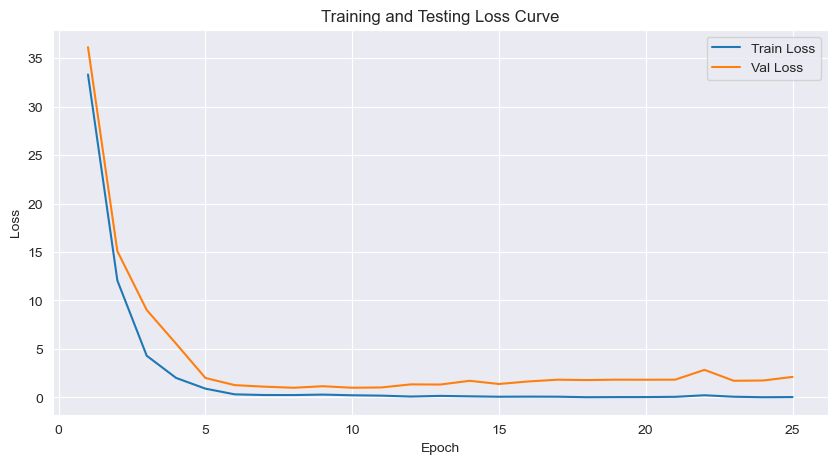

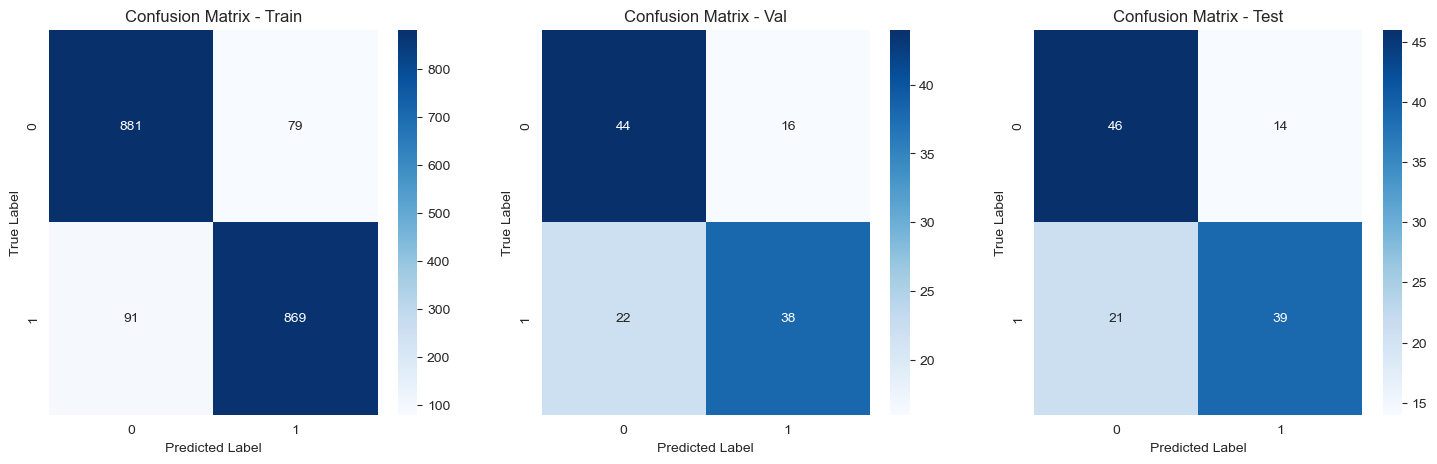

In [62]:
# evaluate model
CNN.load_state_dict (torch.load('best_model_CNN.pth'))

all_train_targets = []
all_train_predictions = []

all_train_targets,all_train_predictions = get_predictions(train_loader, CNN, device)

all_val_targets = []
all_val_predictions = []

all_val_targets,all_val_predictions = get_predictions(val_loader, CNN, device)

all_test_targets = []
all_test_predictions = []

all_test_targets,all_test_predictions = get_predictions(test_loader, CNN, device)

# loss curve
loss_curve(epoches, train_losses, val_losses)

plot_confusion_matrix(all_train_targets,all_train_predictions,all_val_targets,all_val_predictions,all_test_targets,all_test_predictions)



In [63]:
print_confusion_matrix(all_train_targets,all_train_predictions,all_val_targets,all_val_predictions,all_test_targets,all_test_predictions)

torch.cuda.empty_cache()

              precision    recall  f1-score   support

           0       0.91      0.92      0.91       960
           1       0.92      0.91      0.91       960

    accuracy                           0.91      1920
   macro avg       0.91      0.91      0.91      1920
weighted avg       0.91      0.91      0.91      1920

              precision    recall  f1-score   support

           0       0.67      0.73      0.70        60
           1       0.70      0.63      0.67        60

    accuracy                           0.68       120
   macro avg       0.69      0.68      0.68       120
weighted avg       0.69      0.68      0.68       120

              precision    recall  f1-score   support

           0       0.69      0.77      0.72        60
           1       0.74      0.65      0.69        60

    accuracy                           0.71       120
   macro avg       0.71      0.71      0.71       120
weighted avg       0.71      0.71      0.71       120



### Resnet18

In [64]:
pattern = 'Zscore'
X,y = preprocess(df,pattern,default=True)
# X , y = random_sample(X,y)
X_train, X_val, X_test, y_train, y_val,y_test = random_split(X,y)
# X_train, y_train = augment_loop(X_train,y_train,pattern)

In [65]:
X_train = X_train.transpose(0,3,1,2)
X_val = X_val.transpose(0,3,1,2)
X_test = X_test.transpose(0,3,1,2)
X_train.shape

(4813, 3, 224, 224)

In [66]:
torch.manual_seed(2024)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

Resnet18 = models.resnet18(pretrained=True)
Resnet18.fc = nn.Linear(Resnet18.fc.in_features, 2)  # Binary classification (0 and 1)
Resnet18 = Resnet18.to(device)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.FloatTensor(class_weights).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device))
optimizer = optim.Adam(Resnet18.parameters(), lr=0.001, weight_decay=1e-4)

epoches = 25
best_val_accuracy = 0
datas = []
val_datas = []

# Create DataLoaders for training and testing
dataset = ImageDataset(X_train,y_train)
val_dataset = ImageDataset(X_val,y_val)
test_dataset = ImageDataset(X_test,y_test)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
   
train_losses = []
val_losses = []

for epoch in range(epoches):
    Resnet18.train()   
    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device).long()
        optimizer.zero_grad()
        outputs = Resnet18(inputs)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    train_accuracy = calculate_accuracy(train_loader, Resnet18, device)
    val_accuracy = calculate_accuracy(val_loader, Resnet18, device)
    
    print(f"Epoch [{epoch + 1}/{epoches}], "
          f"Loss: {loss.item() / len(train_loader):.4f}, "
          f"Train Accuracy: {train_accuracy:.2f}%, "
          f"Test Accuracy: {val_accuracy:.2f}%")
    
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(Resnet18.state_dict(), 'best_model_resnet18.pth')
    
    train_losses = get_losses(train_losses,train_loader, Resnet18, device)
    val_losses = get_losses(val_losses,val_loader, Resnet18, device)


cuda


C:\Users\CindyHong\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\CindyHong\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/25], Loss: 0.0009, Train Accuracy: 77.89%, Test Accuracy: 76.25%
Epoch [2/25], Loss: 0.0017, Train Accuracy: 88.93%, Test Accuracy: 86.21%
Epoch [3/25], Loss: 0.0036, Train Accuracy: 79.29%, Test Accuracy: 77.08%
Epoch [4/25], Loss: 0.0014, Train Accuracy: 96.95%, Test Accuracy: 95.51%
Epoch [5/25], Loss: 0.0004, Train Accuracy: 89.94%, Test Accuracy: 85.22%
Epoch [6/25], Loss: 0.0002, Train Accuracy: 93.27%, Test Accuracy: 92.69%
Epoch [7/25], Loss: 0.0002, Train Accuracy: 97.13%, Test Accuracy: 92.69%
Epoch [8/25], Loss: 0.0004, Train Accuracy: 99.27%, Test Accuracy: 95.68%
Epoch [9/25], Loss: 0.0008, Train Accuracy: 46.62%, Test Accuracy: 45.68%
Epoch [10/25], Loss: 0.0002, Train Accuracy: 98.55%, Test Accuracy: 95.02%
Epoch [11/25], Loss: 0.0005, Train Accuracy: 99.36%, Test Accuracy: 95.02%
Epoch [12/25], Loss: 0.0001, Train Accuracy: 96.47%, Test Accuracy: 91.53%
Epoch [13/25], Loss: 0.0000, Train Accuracy: 98.63%, Test Accuracy: 95.68%
Epoch [14/25], Loss: 0.0005, Train

C:\Users\CindyHong\AppData\Local\Temp\ipykernel_10848\4006694899.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Resnet18.load_state_dict (torch.load('best_model_resnet1

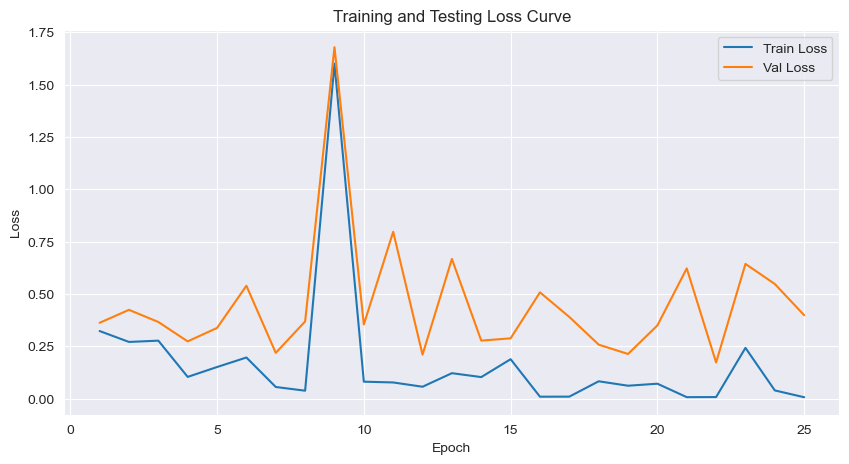

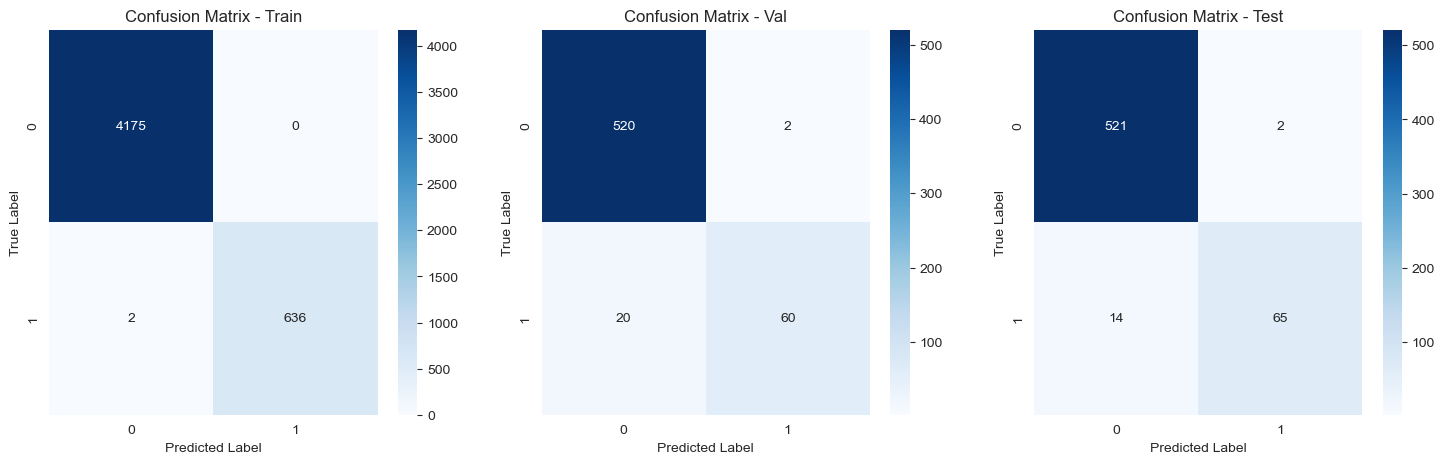

In [67]:
# evaluate model
Resnet18.load_state_dict (torch.load('best_model_resnet18.pth'))

all_train_targets = []
all_train_predictions = []

all_train_targets,all_train_predictions = get_predictions(train_loader, Resnet18, device)

all_val_targets = []
all_val_predictions = []

all_val_targets,all_val_predictions = get_predictions(val_loader, Resnet18, device)

all_test_targets = []
all_test_predictions = []

all_test_targets,all_test_predictions = get_predictions(test_loader, Resnet18, device)

# loss curve
loss_curve(epoches, train_losses, val_losses)

plot_confusion_matrix(all_train_targets,all_train_predictions,all_val_targets,all_val_predictions,all_test_targets,all_test_predictions)



In [68]:
print_confusion_matrix(all_train_targets,all_train_predictions,all_val_targets,all_val_predictions,all_test_targets,all_test_predictions)

torch.cuda.empty_cache()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4175
           1       1.00      1.00      1.00       638

    accuracy                           1.00      4813
   macro avg       1.00      1.00      1.00      4813
weighted avg       1.00      1.00      1.00      4813

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       522
           1       0.97      0.75      0.85        80

    accuracy                           0.96       602
   macro avg       0.97      0.87      0.91       602
weighted avg       0.96      0.96      0.96       602

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       523
           1       0.97      0.82      0.89        79

    accuracy                           0.97       602
   macro avg       0.97      0.91      0.94       602
weighted avg       0.97      0.97      0.97       602



In [27]:
pattern = 'Zscore'
X,y = preprocess(df,pattern,default=True)
# X , y = random_sample(X,y)
X_train, X_val, X_test, y_train, y_val,y_test = random_split(X,y)
X_train, y_train = augment_loop(X_train,y_train,pattern)

In [28]:
X_train = X_train.transpose(0,3,1,2)
X_val = X_val.transpose(0,3,1,2)
X_test = X_test.transpose(0,3,1,2)
X_train.shape

(9626, 3, 224, 224)

In [ ]:
torch.manual_seed(2024)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

Resnet18 = models.resnet18(pretrained=True)
Resnet18.fc = nn.Linear(Resnet18.fc.in_features, 2)  # Binary classification (0 and 1)
Resnet18 = Resnet18.to(device)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.FloatTensor(class_weights).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device))
optimizer = optim.Adam(Resnet18.parameters(), lr=0.001, weight_decay=1e-4)

epoches = 25
best_val_accuracy = 0
datas = []
val_datas = []

# Create DataLoaders for training and testing
dataset = ImageDataset(X_train,y_train)
val_dataset = ImageDataset(X_val,y_val)
test_dataset = ImageDataset(X_test,y_test)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
   
train_losses = []
val_losses = []

for epoch in range(epoches):
    Resnet18.train()   
    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device).long()
        optimizer.zero_grad()
        outputs = Resnet18(inputs)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    train_accuracy = calculate_accuracy(train_loader, Resnet18, device)
    val_accuracy = calculate_accuracy(val_loader, Resnet18, device)
    
    print(f"Epoch [{epoch + 1}/{epoches}], "
          f"Loss: {loss.item() / len(train_loader):.4f}, "
          f"Train Accuracy: {train_accuracy:.2f}%, "
          f"Test Accuracy: {val_accuracy:.2f}%")
    
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(Resnet18.state_dict(), 'best_model_resnet18_aug.pth')
    
    train_losses = get_losses(train_losses,train_loader, Resnet18, device)
    val_losses = get_losses(val_losses,val_loader, Resnet18, device)


cuda


C:\Users\CindyHong\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\CindyHong\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/25], Loss: 0.0016, Train Accuracy: 74.52%, Test Accuracy: 59.30%
Epoch [2/25], Loss: 0.0028, Train Accuracy: 79.33%, Test Accuracy: 73.75%
Epoch [3/25], Loss: 0.0026, Train Accuracy: 71.41%, Test Accuracy: 52.82%
Epoch [4/25], Loss: 0.0020, Train Accuracy: 48.97%, Test Accuracy: 82.06%


In [ ]:
# evaluate model
Resnet18.load_state_dict (torch.load('best_model_resnet18_aug.pth'))

all_train_targets = []
all_train_predictions = []

all_train_targets,all_train_predictions = get_predictions(train_loader, Resnet18, device)

all_val_targets = []
all_val_predictions = []

all_val_targets,all_val_predictions = get_predictions(val_loader, Resnet18, device)

all_test_targets = []
all_test_predictions = []

all_test_targets,all_test_predictions = get_predictions(test_loader, Resnet18, device)

# loss curve
loss_curve(epoches, train_losses, val_losses)

plot_confusion_matrix(all_train_targets,all_train_predictions,all_val_targets,all_val_predictions,all_test_targets,all_test_predictions)



In [ ]:
print_confusion_matrix(all_train_targets,all_train_predictions,all_val_targets,all_val_predictions,all_test_targets,all_test_predictions)

torch.cuda.empty_cache()

# Collaboration Block

## GPT

### Image Transformation Techniques

Use:
how to flip/rotate/shift images
ChatGPT:
Flipping, rotating, or shifting images can be done using various image processing tools or libraries like Photoshop, GIMP, or programming libraries like Python's OpenCV, PIL (Pillow), or NumPy. Below are step-by-step methods depending on the tool you prefer.

---

### **1. Using Python Libraries**

#### a) **Flip Images**

- **Horizontally (mirror flip):**

  ```python
  from PIL import Image
  img = Image.open("image.jpg")
  flipped_img = img.transpose(Image.FLIP_LEFT_RIGHT)
  flipped_img.show()
  flipped_img.save("flipped_image.jpg")
  ```

- **Vertically:**

  ```python
  flipped_img = img.transpose(Image.FLIP_TOP_BOTTOM)
  ```

#### b) **Rotate Images**

- Rotate by an angle (e.g., 90, 180 degrees):

  ```python
  rotated_img = img.rotate(90)  # Counter-clockwise rotation
  rotated_img.show()
  ```

#### c) **Shift Images**

To shift an image (translate):

- Using OpenCV:

  ```python
  import cv2
  import numpy as np
  img = cv2.imread("image.jpg")
  rows, cols = img.shape[:2]
  M = np.float32([[1, 0, 50], [0, 1, 100]])  # Shift by 50px right and 100px down
  shifted_img = cv2.warpAffine(img, M, (cols, rows))
  cv2.imshow("Shifted", shifted_img)
  cv2.waitKey(0)
  ```

---

### **2. Using Photoshop**

#### a) **Flip Images**

- Open your image in Photoshop.
- Go to **Edit > Transform > Flip Horizontal** (or Flip Vertical).

#### b) **Rotate Images**

- Go to **Image > Image Rotation** and select an angle (e.g., 90° CW, 180°).

#### c) **Shift Images**

- Use the **Move Tool (V)** and drag the image manually.

---

### **3. Using GIMP**

#### a) **Flip Images**

- Open your image in GIMP.
- Go to **Image > Transform > Flip Horizontally** or **Flip Vertically**.

#### b) **Rotate Images**

- Go to **Image > Transform > Rotate** and choose the desired angle.

#### c) **Shift Images**

- Use the **Move Tool** or the **Offset Tool** (Filters > Map > Offset).

---

### **4. Online Tools**

Websites like **Canva**, **Fotor**, or **Photopea** allow flipping, rotating, and shifting images:

1. Upload your image.
2. Use their tools to apply the desired transformation.

Let me know which tool you'd like detailed guidance on!

### Releasing Storage in Image Analysis

User:
How to release storage when analyzing image data
ChatGPT:
When analyzing image data, especially if you're working with large datasets or processing multiple images, you may encounter memory and storage limitations. Efficiently managing your storage and memory is crucial to maintaining performance and avoiding crashes or slowdowns. Here are several strategies to help you release storage or optimize memory usage during image analysis:

### 1. **Delete Unused Variables**  

If you are working with image data in a programming environment (e.g., Python), make sure to delete or dereference variables that are no longer needed. For example, in Python:

   ```python
del variable_name
   ```

   This releases the memory occupied by the variable, although in Python, garbage collection may still be delayed. Using `gc.collect()` after deleting variables can force garbage collection:

   ```python
import gc
gc.collect()
   ```

### 2. **Use Efficient Image Formats**  

Images can occupy a lot of space depending on their format and resolution. When analyzing large datasets:

   - **Convert to compressed formats**: Convert images to a compressed format like JPEG or PNG (for lossless compression). TIFF files, for example, can be very large and inefficient.
   - **Downsample the images**: If high resolution is not required, downsample the images (reduce the pixel dimensions) before performing the analysis.
   - **Use specialized image formats for analysis**: Formats like `.npz` (for NumPy arrays) or `.h5` (HDF5) are efficient for storing large datasets and can be accessed in chunks.

### 3. **Process Images in Chunks**  

Instead of loading and processing all images at once:

   - **Load and process images in batches or chunks**: Instead of reading an entire directory of images into memory, process them in smaller groups.
   - **Use generators** (if using Python): These allow you to load and process images on-the-fly, releasing memory as soon as a batch is processed.
     Example using a Python generator:

   ```python
def image_batch_generator(image_list, batch_size):
    for i in range(0, len(image_list), batch_size):
        yield image_list[i:i+batch_size]
   ```

### 4. **Avoid Duplicating Data**  

Be cautious when performing operations on image data:

   - **Avoid making unnecessary copies** of image arrays when processing or transforming them.
   - When working with libraries like NumPy or OpenCV, prefer operations that modify the image in place, or be careful with assignments that create copies unintentionally.
     Example in NumPy:

   ```python
image = np.array(image)  # This might create an extra copy
   ```

### 5. **Use Lazy Loading Techniques**  

If you're analyzing a large dataset of images (e.g., in a deep learning context), you can use libraries that implement lazy loading to only load data into memory when necessary:

   - **TensorFlow**: Use `tf.data.Dataset` to load images in batches without keeping everything in memory.
   - **PyTorch**: Use `DataLoader` with `torchvision`'s `ImageFolder` to load images on demand.

### 6. **Optimize Image Preprocessing**  

Many image preprocessing operations (like resizing, normalization, etc.) can be memory-intensive. To optimize:

   - **Perform operations on the fly** rather than saving intermediate results, especially for large datasets.
   - **Use in-place operations** (if the library supports it) to reduce memory usage.

### 7. **Clear Temporary Files**  

If you are saving intermediate results (like processed images, analysis outputs, or temporary files), make sure to clean them up:

   - **Delete temporary images or results** after they are no longer needed.
   - **Use disk caching** for large datasets, where the intermediate data is stored on disk and read when necessary.

### 8. **Use Disk Storage for Large Datasets**  

When working with particularly large datasets:

   - **Store images on disk** and load them into memory only when required.
   - For large image datasets, consider using **database storage solutions** like SQLite, HDF5, or even cloud storage with API access.

### 9. **Offload Image Processing Tasks**  

If you are processing large datasets and your local system's resources are insufficient, consider:

   - **Cloud services** or distributed computing (e.g., AWS, Google Cloud, or Microsoft Azure) to offload the computation and storage.

### 10. **Use Sparse Representations (if applicable)**  

If you are dealing with sparse images (e.g., most of the image data is background or empty), use sparse matrices or compressed storage formats (e.g., `scipy.sparse` matrices) to save space and memory.

### 11. **Use Memory-Mapped Files**  

For very large datasets, consider using memory-mapped files (which allows you to access small sections of the data without loading everything into memory). For example, NumPy has support for memory-mapped arrays:

   ```python
image_data = np.memmap('large_image_data.npy', dtype='float32', mode='r', shape=(1000, 1000))
   ```

### 12. **Optimize Image Loading Libraries**  

Some libraries offer options to manage memory usage during image loading:

   - **OpenCV**: OpenCV’s `imread()` function supports reading images in different color modes. You can read images as grayscale or use reduced precision (e.g., `uint8` instead of `float64`) to reduce memory usage.
   - **Pillow**: The Python Imaging Library (Pillow) allows you to load and manipulate images efficiently.

### 13. **Monitor Memory Usage**  

If you are unsure about memory usage, use tools to monitor your program’s memory consumption:

   - **Python**: Use `psutil` or `memory_profiler` to track memory usage and identify potential bottlenecks.
   - **System tools**: On Linux or macOS, tools like `htop` or `top` can be used to monitor memory usage.

By combining these strategies, you can significantly reduce memory consumption and optimize storage management while analyzing image data, allowing for more efficient processing and analysis.



### New chat

User:
Here's my CNN but it doesn't perform well.Please help me modifying it.
class CNN(nn.Module): 
    def __init__(self,image_size=(3,224,224), num_classes=2,dropout = 0.25):
        super(CNN, self).__init__()
        c,h,w = image_size
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)
        self.flattened_size = 128 * (h // 4) * (w // 4) 
        self.fc = nn.Linear(self.flattened_size, num_classes)
        
    def forward(self, x):
        x = F.relu(self.conv1(x)) 
        x = self.pool(x)
        x = F.relu(self.conv2(x)) 
        x = self.pool(x)
        
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

ChatGPT:
Your current CNN architecture has a simple structure, but there are several improvements you can make to enhance its performance, especially if it struggles with accuracy or overfitting. Here's a modified version of your model with explanations for the changes:

### Key Modifications:

1. **Additional Convolutional Layers**:
   - Increase depth by adding more convolutional layers to better capture complex features.

2. **Batch Normalization**:
   - Add batch normalization layers to stabilize training and improve convergence.

3. **Dropout**:
   - Use dropout to reduce overfitting.

4. **Adaptive Pooling**:
   - Replace fixed pooling with adaptive pooling to make the network more flexible for varying input sizes.

5. **Better Fully Connected Layers**:
   - Add one or more fully connected layers with activation functions to learn more complex mappings.

6. **Improved Kernel Sizes**:
   - Use a mix of kernel sizes for convolutions to capture features of different scales.

Here’s the revised code:

```python
import torch
import torch.nn as nn
import torch.nn.functional as F

class EnhancedCNN(nn.Module):
    def __init__(self, image_size=(3, 224, 224), num_classes=2, dropout=0.5):
        super(EnhancedCNN, self).__init__()
        c, h, w = image_size
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(c, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        
        # Pooling and dropout
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout)
        
        # Adaptive pooling for flexibility with input size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Fully connected layers
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        # Convolutional layers with activation, batch normalization, and pooling
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.adaptive_pool(x)
        
        # Flatten the tensor for fully connected layers
        x = torch.flatten(x, 1)
        
        # Fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x
```

### Improvements Explained:

1. **More Layers**:
   - Adding an extra convolutional layer (`conv3`) improves the ability of the network to learn more complex patterns.

2. **Batch Normalization**:
   - Helps stabilize training and reduces sensitivity to initialization.

3. **Dropout**:
   - Dropout between the fully connected layers prevents overfitting.

4. **Adaptive Pooling**:
   - Ensures that the model can handle varying input sizes by reducing the feature map to a fixed size.

5. **Flexible Fully Connected Layers**:
   - Two fully connected layers allow the model to learn more complex feature mappings.

### Training Tips:

- Use data augmentation (e.g., flipping, rotation) to increase the diversity of training data.
- Use a learning rate scheduler like `ReduceLROnPlateau` to dynamically adjust the learning rate.
- Monitor validation performance to prevent overfitting.

Let me know if you need help with training or debugging this model!

